## TO DO
1. try a couple other tests, wr?ite summaries
3. feature engineering methods


## Things tried:
1. Auto feature selection:
    - f regression
2. Drop between bioreps
    - cosine similarity
    - pearson
    - spearman
    - 
3. Other
    - spearman with target
     


## things still to try:
    - covariance - between bioreps?
    - variance threshold
    - PCA
    - recursive?
    - selectbest - that eliminates features AFTER choosing the model?


Still need to: analyze the scores for different params tried

## Questions
- do i need to be using standard scalar?
    - also, should I avoid using standard scaler when the data is reshaped this way?
- just noticed there are more than 2 bioreps - what does this mean for the analysis done so far?

In [496]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics.pairwise import cosine_similarity


from sklearn.metrics import make_scorer

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [500]:
train_data = pd.read_csv("SubCh1_TrainingData.csv")
test_data = pd.read_csv("SubCh1_TestData.csv")

train_data['Timepoint'] = [1 if i == '24HR' else 0 for i in train_data['Timepoint']]
train_data['Treatment'] = [1 if i == 'DHA' else 0 for i in train_data['Treatment']]
train_data['BioRep'] = [int(i[-1]) for i in train_data['BioRep']]

genes = list(train_data.drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis=1).columns)

print(train_data.shape)
train_data.head()

(272, 5546)


,Sample_Name,Isolate,Timepoint,Treatment,BioRep,MAL1.465720.465873.bc..rv..,MAL1.48287.48430....kr...can,MAL1.562126.562246.bc..r...,MAL1.59416.59687....kr...can,MAL1.616633.616682.......y.,...,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479700,PF3D7_1479800,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100,DHA_IC50
0,isolate_01.24HR.DHA.BRep1,isolate_01,1,1,1,0.008286,-0.959492,0.206468,-0.443936,0.453030,...,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528,2.177
1,isolate_01.24HR.DHA.BRep2,isolate_01,1,1,2,-0.872028,-1.968558,-2.308563,-1.186611,0.508575,...,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568,2.177
2,isolate_01.24HR.UT.BRep1,isolate_01,1,0,1,0.039480,-1.291371,-0.946661,-0.538092,-1.778501,...,1.411557,-5.500522,-1.764229,-1.947208,-5.331037,-0.814417,-2.141285,-3.922684,-2.495169,2.177
3,isolate_01.24HR.UT.BRep2,isolate_01,1,0,2,0.125177,-1.462758,-1.888105,-0.828352,-1.410803,...,-0.659519,-5.011207,-0.559471,-2.266763,-5.289318,-2.949869,-2.206432,-4.324299,-1.735312,2.177
4,isolate_01.6HR.DHA.BRep1,isolate_01,0,1,1,1.354956,-2.139128,-0.541696,-1.481881,-0.735798,...,-1.687048,-4.773306,-0.048847,-2.023727,-4.398358,-3.080500,-0.566545,-4.798190,-0.821690,2.177


In [478]:
X_A = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_B = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_C = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_D = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)

# rename columns:
X_A.columns = ['A' + str(i) for i in range(1,5541)]
X_B.columns = ['B' + str(i) for i in range(1,5541)]
X_C.columns = ['C' + str(i) for i in range(1,5541)]
X_D.columns = ['D' + str(i) for i in range(1,5541)]

X_A = X_A.reset_index().drop(['index'],axis=1)
X_B = X_B.reset_index().drop(['index'],axis=1)
X_C = X_C.reset_index().drop(['index'],axis=1)
X_D = X_D.reset_index().drop(['index'],axis=1)

# combine data frames:
X = pd.concat([X_A,X_B,X_C,X_D], axis=1)
print(X.shape)
X.head(5)


(68, 22160)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D5531,D5532,D5533,D5534,D5535,D5536,D5537,D5538,D5539,D5540
0,1.311350,-1.613464,-1.298663,-1.441343,-1.735923,0.173112,2.466366,1.383979,-0.115130,0.287468,...,0.210607,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528
1,0.997722,-1.553994,-1.960600,-1.424590,0.023609,0.420973,1.128427,0.722659,1.878123,-0.065159,...,-0.447109,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568
2,0.389508,-2.139782,-0.584985,-1.085373,0.803247,0.766617,1.701689,0.926101,1.600687,0.435633,...,-0.070151,0.024133,-2.215227,-1.957654,-2.188635,-4.424748,-2.986927,-1.722201,-3.995680,-0.902979
3,0.348560,-1.562540,-0.586732,-0.834661,1.096979,0.121817,1.623373,-0.654405,0.221121,0.998601,...,-1.288305,0.806314,-3.733712,-1.990368,-1.633418,-5.533077,-3.283316,-2.104227,-5.767710,-2.177930
4,0.138276,-1.612280,-1.362990,-1.360318,0.488124,0.365410,0.739845,-0.654702,2.170263,0.630418,...,0.279816,0.115002,-1.305902,-0.679212,-2.099512,-5.955507,-0.920594,-1.626372,-4.422711,-1.408485


In [479]:
y = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)][['DHA_IC50']]
y.reset_index(inplace = True, drop = True)
print(y.shape)
y.head(2)

(68, 1)


,DHA_IC50
0,2.177
1,2.177


#### Q: are these values centered?  No (the mean is not zero)

In [501]:
print(train_data.shape)
# train_data.iloc[:, [0,1, 2, 3]].describe()
print(train_data.iloc[:, [4, 5, 6]].describe())
train_data.iloc[:, [4, 5, 6]]

(272, 5546)
           BioRep  MAL1.465720.465873.bc..rv..  MAL1.48287.48430....kr...can
count  272.000000                   272.000000                    272.000000
mean     1.911765                     0.125273                     -1.512177
std      1.360869                     0.542060                      0.502683
min      1.000000                    -1.250413                     -2.535058
25%      1.000000                    -0.233872                     -1.863514
50%      2.000000                     0.130822                     -1.551020
75%      2.000000                     0.471552                     -1.244585
max      8.000000                     1.530355                      0.893645


,BioRep,MAL1.465720.465873.bc..rv..,MAL1.48287.48430....kr...can
0,1,0.008286,-0.959492
1,2,-0.872028,-1.968558
2,1,0.039480,-1.291371
3,2,0.125177,-1.462758
4,1,1.354956,-2.139128
5,2,-0.218074,-1.068870
6,1,1.311350,-1.613464
7,2,0.997722,-1.553994
8,1,-0.178971,-1.922426
9,2,1.337421,-1.764941


In [520]:
ss = StandardScaler()


test = train_data.iloc[:, [4, 5, 6]]
test_scaled = ss.fit_transform(test)
test_scaled.shape


print(test_scaled[:, 0].mean())
print(np.mean(test_scaled[:, 0]))
print(np.std(test_scaled[:, 0]))


-1.0449157878825003e-16
-1.0449157878825003e-16
1.0


In [43]:
def spear_r(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

## f_regression analysis
#### gridsearch

In [270]:
a_name = ['A' + str(i) for i in range(1,5541)]
b_name = ['B' + str(i) for i in range(1,5541)]
c_name = ['C' + str(i) for i in range(1,5541)]
d_name = ['D' + str(i) for i in range(1,5541)]

xa = X.loc[:,a_name]
xb = X.loc[:,b_name]
xc = X.loc[:,c_name]
xd = X.loc[:,d_name]

df_list = [X, xa, xb, xc, xd]

for i in df_list:
    df_fbest = SelectKBest(f_regression, k=200).fit_transform(i, y.values.ravel()) 
    df_fbest  = pd.DataFrame(data = df_fbest )

    X_train, X_test, y_train, y_test = train_test_split(df_fbest, y.values.ravel(), test_size = 0.33, random_state = 42)

    svc = svm.SVR()
    params = {        
             'kernel': ['rbf', 'poly', 'sigmoid'],
                  'C': [0.01, 0.1, 1, 5],
            'epsilon': [0.01,  0.1, 0.2],
              'gamma': [0.001, 0.01, 'auto'], 
             'degree': [2, 4, 6, 8],
             }

    scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}

    gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                  return_train_score=True, scoring = scoring, refit = 'spear_r')
    gs.fit(X_train, y_train) 
    scores = pd.DataFrame(gs.cv_results_)
    condition = scores['rank_test_spear_r'] == 1
    df_1 = scores[condition].reset_index(drop = True)
    print(df_1['params'].values)
    print(df_1.loc[:, ['mean_test_spear_r', 'mean_test_r2', 'mean_train_spear_r', 'mean_train_r2'  ]])
    
    

[{'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'rbf'}
 {'C': 5, 'degree': 4, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'rbf'}
 {'C': 5, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'rbf'}
 {'C': 5, 'degree': 8, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'rbf'}]
   mean_test_spear_r  mean_test_r2  mean_train_spear_r  mean_train_r2
0           0.623864      0.299971            0.890202       0.710023
1           0.623864      0.299971            0.890202       0.710023
2           0.623864      0.299971            0.890202       0.710023
3           0.623864      0.299971            0.890202       0.710023
[{'C': 0.01, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'}
 {'C': 0.01, 'degree': 6, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}
 {'C': 0.1, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'}
 {'C': 1, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'}
 {'C': 5, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.001, 'kern

####  f-regression score

In [275]:
results_df = pd.DataFrame(index = X.index, columns = ['Actual', 'All', 'xA', 'xB', 'xC', 'xD'])
results_df['Actual'] = y['DHA_IC50']

df_list = [X, xa, xb, xc, xd]

for i in enumerate(df_list):  
    df_fbest = SelectKBest(f_regression, k=5).fit_transform(i[1], y.values.ravel()) 
    df_fbest  = pd.DataFrame(data = df_fbest )
    
    X_train, X_test, y_train, y_test = train_test_split(df_fbest, y.values.ravel(), 
                                                test_size = 0.33, random_state = 42)

    svc = svm.SVR(kernel = 'poly', C = 0.1, degree = 2, epsilon = 0.2, gamma = 0.01)


    model = svc.fit(X_train, y_train)
    pred = model.predict(X_test)

#     print("cv_spear:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring=make_scorer(spear_r)).mean() )
#     print("cv_r^2:  ", cross_val_score(svc, X_train, y_train, cv = 3).mean() )
#     print("cv_mse:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error').mean() )
#     print("---------------------------")
    print("spearman", round(spearmanr(y_test, pred)[0], 3), round(spearmanr(y_test, pred)[1], 3) ) 
#     print("r^2", r2_score(y_test, pred) ) 
#     print("mse", mean_squared_error(y_test, pred) ) 
#     print("----------------------------")
#     print("train score:", model.score(X_train, y_train))
#     print("test score:    ", model.score(X_test, y_test)) 
    print("-----------------------------------------------------------------------------")
    
    for j in enumerate(X_test.index):
        results_df.loc[j[1], results_df.columns[i[0]+1]] = round(float(pred[j[0]]), 3)
    
results_df = results_df.dropna(subset = ['xA'])
results_df = results_df.astype(float)
results_df



spearman 0.248 0.254
-----------------------------------------------------------------------------
spearman 0.497 0.016
-----------------------------------------------------------------------------
spearman 0.431 0.04
-----------------------------------------------------------------------------
spearman 0.125 0.569
-----------------------------------------------------------------------------
spearman 0.131 0.552
-----------------------------------------------------------------------------


,Actual,All,xA,xB,xC,xD
0,2.1770,1.554,1.565,1.552,1.554,1.552
4,1.6970,1.554,1.549,1.565,1.553,1.554
5,1.6970,1.554,1.548,1.561,1.554,1.553
7,1.7990,1.554,1.553,1.563,1.553,1.557
9,0.7100,1.554,1.546,1.544,1.554,1.553
12,1.3670,1.554,1.555,1.557,1.554,1.553
16,3.4600,1.554,1.553,1.556,1.554,1.558
19,1.7650,1.554,1.556,1.557,1.554,1.554
25,1.5170,1.554,1.548,1.557,1.554,1.554
28,1.4700,1.554,1.549,1.569,1.554,1.554


In [276]:
results_df.describe()

,Actual,All,xA,xB,xC,xD
count,23.000000,2.300000e+01,23.000000,23.000000,23.000000,23.000000
mean,1.626187,1.554000e+00,1.551565,1.556000,1.553913,1.554000
std,0.552998,4.540700e-16,0.004775,0.006626,0.000288,0.001477
min,0.693300,1.554000e+00,1.546000,1.543000,1.553000,1.552000
25%,1.348000,1.554000e+00,1.548500,1.552000,1.554000,1.553000
50%,1.647000,1.554000e+00,1.550000,1.557000,1.554000,1.554000
75%,1.782000,1.554000e+00,1.554000,1.560000,1.554000,1.554500
max,3.460000,1.554000e+00,1.565000,1.569000,1.554000,1.558000


In [245]:
results_df['Avg_4'] = (results_df['xA'] + results_df['xB'] + results_df['xC'] + results_df['xD']) / 4

results_df['Avg_ad'] = (results_df['xA'] + results_df['xD']) / 2
results_df['Avg_ac'] = (results_df['xA'] + results_df['xC']) / 2
results_df['Avg_ab'] = (results_df['xA'] + results_df['xB']) / 2  

results_df['Avg_bc'] = (results_df['xB'] + results_df['xC']) / 2 
results_df['Avg_bd'] = (results_df['xB'] + results_df['xD']) / 2 

results_df['Avg_cd'] = (results_df['xC'] + results_df['xD']) / 2 

results_df
print('Avg_4', round(spearmanr(results_df['Avg_4'], results_df['Actual'])[0], 3))
print("------------------------------------------------")
print('ad', round(spearmanr(results_df['Avg_ad'], results_df['Actual'])[0], 3))
print('ac', round(spearmanr(results_df['Avg_ac'], results_df['Actual'])[0], 3))
print('ab', round(spearmanr(results_df['Avg_ab'], results_df['Actual'])[0], 3))
print("------------------------------------------------")
print('bc', round(spearmanr(results_df['Avg_bc'], results_df['Actual'])[0], 3))
print('bd', round(spearmanr(results_df['Avg_bd'], results_df['Actual'])[0], 3))
print('cd', round(spearmanr(results_df['Avg_cd'], results_df['Actual'])[0], 3))



Avg_4 0.629
------------------------------------------------
ad 0.377
ac 0.5
ab 0.685
------------------------------------------------
bc 0.527
bd 0.501
cd 0.368


#### biorep investigation



In [ ]:

X_cos = i.loc[:]
X_cos['BioRep'] = train_data['BioRep'] 
reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
X_cos = X_cos.drop(columns= ['BioRep'])

## cosine siimlarity between bioreps analysis

In [397]:
a_name = ['A' + str(i) for i in range(1,5541)]
b_name = ['B' + str(i) for i in range(1,5541)]
c_name = ['C' + str(i) for i in range(1,5541)]
d_name = ['D' + str(i) for i in range(1,5541)]

xa = X.loc[:,a_name]
xb = X.loc[:,b_name]
xc = X.loc[:,c_name]
xd = X.loc[:,d_name]

df_list = [X, xa, xb, xc, xd]

In [386]:
df_list = [X, xa, xb, xc, xd]

for i in df_list:
    
    X_cos = i.loc[:]
    X_cos['BioRep'] = train_data['BioRep'] 
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])
    
    drop_point = 0.7
    names = []
    
    for k in range(len(X_cos.columns)):
          if cosine_similarity(reps2.values[:,k].reshape(1, -1),reps1.values[:,k].reshape(1, -1))[0][0] < drop_point:
                names.append(X_cos.columns[k])
    
    X_new = X_cos.drop(names,axis=1)
    
    

    X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size = 0.33, random_state = 42)

    svc = svm.SVR()
    params = {        
             'kernel': ['rbf', 'poly', 'sigmoid'],
                  'C': [0.01, 0.1, 1, 5],
            'epsilon': [0.01,  0.1, 0.2],
              'gamma': [0.001, 0.01, 'auto'], 
             'degree': [2, 4, 6, 8],
             }

    scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}

    gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                  return_train_score=True, scoring = scoring, refit = 'spear_r')
    gs.fit(X_train, y_train) 
    scores = pd.DataFrame(gs.cv_results_)
    condition = scores['rank_test_spear_r'] == 1
    df_1 = scores[condition].reset_index(drop = True)
    print(df_1['params'].values)
    print(len(X_new.columns))
    print(df_1.loc[:, ['mean_test_spear_r', 'mean_test_r2', 'mean_train_spear_r', 'mean_train_r2'  ]])
    print("----------------------------------------------------------------------------------------------")
    

[{'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.01, 'degree': 4, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.01, 'degree': 6, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.01, 'degree': 8, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.1, 'degree': 6, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.1, 'degree': 8, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}]
3468
   mean_test_spear_r  mean_test_r2  mean_train_spear_r  mean_train_r2
0            0.46899     -0.145383            0.791884      -0.009234
1            0.46899     -0.145383            0.791884      -0.009234
2            0.46899     -0.145383            0.791884      -0.009234
3            0.46899     -0.145383            0.791884      -0.009234
4            0.46899     -0.117934            0.

In [401]:
results_df = pd.DataFrame(index = X.index, columns = ['Actual', 'All', 'xA', 'xB', 'xC', 'xD'])
results_df['Actual'] = y['DHA_IC50']

df_list = [X, xa, xb, xc, xd]

for i in enumerate(df_list):
    X_cos = i[1].loc[:]
    X_cos['BioRep'] = train_data['BioRep'] 
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])
    
    drop_point = 0.9
    names = []
    
    for k in range(len(X_cos.columns)):
        if cosine_similarity(reps2.values[:,k].reshape(1, -1),reps1.values[:,k].reshape(1, -1))[0][0] < drop_point:
            names.append(X_cos.columns[k])

    X_new = X_cos.drop(names,axis=1)

    
    X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size = 0.33, random_state = 42)
    
    

    svc = svm.SVR(kernel = 'rbf', C = 0.1, degree = 2, epsilon = 0.1, gamma = 'auto')


    model = svc.fit(X_train, y_train)
    pred = model.predict(X_test)

#     print("cv_spear:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring=make_scorer(spear_r)).mean() )
#     print("cv_r^2:  ", cross_val_score(svc, X_train, y_train, cv = 3).mean() )
#     print("cv_mse:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error').mean() )
#     print("---------------------------")
    print("spearman", round(spearmanr(y_test, pred)[0], 3), round(spearmanr(y_test, pred)[1], 3) )
    print(len(X_new.columns))
#     print("r^2", r2_score(y_test, pred) ) 
#     print("mse", mean_squared_error(y_test, pred) ) 
#     print("----------------------------")
#     print("train score:", model.score(X_train, y_train))
#     print("test score:    ", model.score(X_test, y_test)) 
    print("-----------------------------------------------------------------------------")
    
    for j in enumerate(X_test.index):
        results_df.loc[j[1], results_df.columns[i[0]+1]] = round(float(pred[j[0]]), 3)
    
results_df = results_df.dropna(subset = ['xA'])
results_df = results_df.astype(float)
results_df

spearman -0.327 0.128
505
-----------------------------------------------------------------------------
spearman -0.416 0.048
142
-----------------------------------------------------------------------------
spearman -0.217 0.32
135
-----------------------------------------------------------------------------
spearman 0.247 0.255
106
-----------------------------------------------------------------------------
spearman 0.082 0.711
122
-----------------------------------------------------------------------------


,Actual,All,xA,xB,xC,xD
0,2.1770,1.579,1.597,1.588,1.557,1.535
4,1.6970,1.552,1.534,1.632,1.518,1.633
5,1.6970,1.538,1.500,1.522,1.612,1.586
7,1.7990,1.547,1.526,1.575,1.510,1.491
9,0.7100,1.562,1.544,1.554,1.612,1.536
12,1.3670,1.538,1.605,1.464,1.572,1.593
16,3.4600,1.503,1.491,1.435,1.584,1.503
19,1.7650,1.554,1.571,1.580,1.639,1.498
25,1.5170,1.561,1.492,1.582,1.553,1.500
28,1.4700,1.498,1.573,1.497,1.611,1.586


***so far the treated 6 hr seems to be the most interesting in that it has a MUCH higher score than all the rest whenever params are changed --> the others largely have a neg spear score**
- also, why isn't this reproducing like it was before?? - like why isnt the treated_24 scoring as high as it did?

In [391]:
results_df.describe()

,Actual,All,xA,xB,xC,xD
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,1.626187,1.551348,1.565174,1.549391,1.551739,1.565522
std,0.552998,0.026116,0.039246,0.066474,0.045277,0.039012
min,0.693300,1.506000,1.494000,1.425000,1.465000,1.498000
25%,1.348000,1.534500,1.550000,1.517000,1.516500,1.540500
50%,1.647000,1.555000,1.560000,1.566000,1.566000,1.559000
75%,1.782000,1.564500,1.580000,1.590000,1.581500,1.592500
max,3.460000,1.602000,1.643000,1.650000,1.623000,1.647000


In [308]:
results_df['Avg_4'] = (results_df['xA'] + results_df['xB'] + results_df['xC'] + results_df['xD']) / 4

results_df['Avg_ad'] = (results_df['xA'] + results_df['xD']) / 2
results_df['Avg_ac'] = (results_df['xA'] + results_df['xC']) / 2
results_df['Avg_ab'] = (results_df['xA'] + results_df['xB']) / 2  

results_df['Avg_bc'] = (results_df['xB'] + results_df['xC']) / 2 
results_df['Avg_bd'] = (results_df['xB'] + results_df['xD']) / 2 

results_df['Avg_cd'] = (results_df['xC'] + results_df['xD']) / 2 

results_df
print('Avg_4', round(spearmanr(results_df['Avg_4'], results_df['Actual'])[0], 3))
print("------------------------------------------------")
print('ad', round(spearmanr(results_df['Avg_ad'], results_df['Actual'])[0], 3))
print('ac', round(spearmanr(results_df['Avg_ac'], results_df['Actual'])[0], 3))
print('ab', round(spearmanr(results_df['Avg_ab'], results_df['Actual'])[0], 3))
print("------------------------------------------------")
print('bc', round(spearmanr(results_df['Avg_bc'], results_df['Actual'])[0], 3))
print('bd', round(spearmanr(results_df['Avg_bd'], results_df['Actual'])[0], 3))
print('cd', round(spearmanr(results_df['Avg_cd'], results_df['Actual'])[0], 3))


Avg_4 -0.143
------------------------------------------------
ad -0.169
ac 0.141
ab -0.322
------------------------------------------------
bc -0.058
bd -0.332
cd 0.133


In [ ]:
pearsonr()

## pearson between bioreps
- NEED TO KEEP investigating the score - what params give it a certain score and resulting predictions
 

In [439]:
np.arange(0.2, 0.5, 0.05)

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])

#### search threshold

In [446]:

dataframe = []
threshold = []
n_features = []
accuracy = []
mse = []
spearman = []
num_cols = []

df_list = [X, xa, xb, xc, xd]

for i in enumerate(df_list):
    X_cos = i[1].loc[:]
    
    X_cos['BioRep'] = train_data['BioRep'] 
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])





    for j in np.arange(0.2, 0.5, 0.05):
        drop_point = j
        names = []

        for k in range(len(X_cos.columns)):
            if pearsonr(reps2.iloc[:, k], reps1.iloc[:, k])[0] < drop_point:
                names.append(X_cos.columns[k])


        X_new = X_cos.drop(names,axis=1)


        X_train, X_test , y_train , y_test = train_test_split(X_new, y.values.ravel(), test_size=0.33,random_state=42)


        svc = svm.SVR(kernel = 'poly', degree = 2, C= 0.1)
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)

        dataframe.append(i[0])
        threshold.append(j)
        accuracy.append(model.score(X_test, y_test))
        mse.append(mean_squared_error(y_test, pred))
        spearman.append(spearmanr(y_test, pred)[0])
        num_cols.append(len(X_new.columns))



pear_thresh = pd.DataFrame(list(zip(dataframe, threshold,accuracy,mse,spearman,num_cols)),
                           columns =['datafrane','threshold', 'accuracy','mse','spearman','num_cols']) 

    

In [468]:
pear_thresh

,datafrane,threshold,accuracy,mse,spearman,num_cols
0,0,0.20,0.012440,0.288872,0.293361,2252
1,0,0.25,0.026619,0.284724,0.349357,1352
2,0,0.30,0.035730,0.282059,0.424184,758
3,0,0.35,0.040168,0.280761,0.314174,404
4,0,0.40,0.014500,0.288269,0.283450,205
5,0,0.45,0.013097,0.288680,0.364224,84
6,1,0.20,-0.029546,0.301153,-0.076314,447
7,1,0.25,-0.010527,0.295590,0.027750,264
8,1,0.30,0.000687,0.292309,0.069376,141
9,1,0.35,0.012808,0.288764,0.122894,76


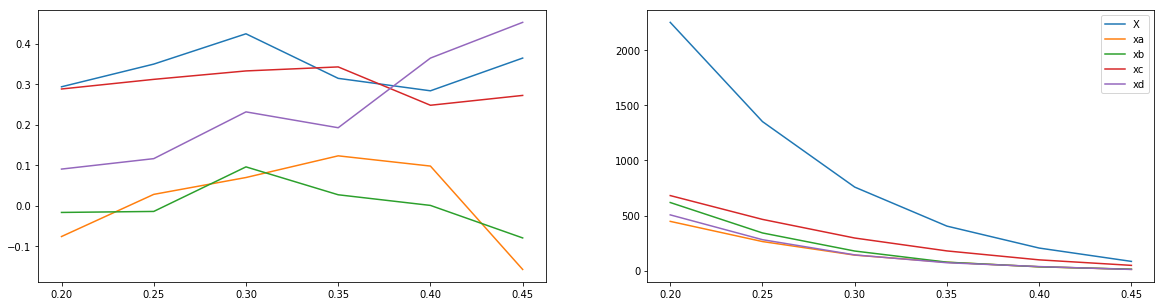

In [460]:
condition_1 = pear_thresh[pear_thresh['datafrane'] == 0]
condition_2 = pear_thresh[pear_thresh['datafrane'] == 1]
condition_3 = pear_thresh[pear_thresh['datafrane'] == 2]
condition_4 = pear_thresh[pear_thresh['datafrane'] == 3]
condition_5 = pear_thresh[pear_thresh['datafrane'] == 4]

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(condition_1['threshold'], condition_1['spearman'], label = 'X')
plt.plot(condition_2['threshold'], condition_2['spearman'], label = 'xa')
plt.plot(condition_3['threshold'], condition_3['spearman'], label = 'xb')
plt.plot(condition_4['threshold'], condition_4['spearman'], label = 'xc')
plt.plot(condition_5['threshold'], condition_5['spearman'], label = 'xd')

plt.subplot(122)
plt.plot(condition_1['threshold'], condition_1['num_cols'], label = 'X')
plt.plot(condition_2['threshold'], condition_2['num_cols'], label = 'xa')
plt.plot(condition_3['threshold'], condition_3['num_cols'], label = 'xb')
plt.plot(condition_4['threshold'], condition_4['num_cols'], label = 'xc')
plt.plot(condition_5['threshold'], condition_5['num_cols'], label = 'xd')
plt.legend()

#### gridsearch params - use a drop_point = 0.3

In [462]:
df_list = [X, xa, xb, xc, xd]

for i in df_list:
    
    X_cos = i.loc[:]
    X_cos['BioRep'] = train_data['BioRep'] 
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])
    
    drop_point = 0.3
    names = []
    
    for k in range(len(X_cos.columns)):
          if pearsonr(reps2.iloc[:, k], reps1.iloc[:, k])[0] < drop_point:
                names.append(X_cos.columns[k])
    
    X_new = X_cos.drop(names,axis=1)
    
    

    X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size = 0.33, random_state = 42)

    svc = svm.SVR()
    params = {        
             'kernel': ['rbf', 'poly', 'sigmoid'],
                  'C': [0.01, 0.1, 1, 5],
            'epsilon': [0.01,  0.1, 0.2],
              'gamma': [0.001, 0.01, 'auto'], 
             'degree': [2, 4, 6, 8],
             }

    scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}

    gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                  return_train_score=True, scoring = scoring, refit = 'spear_r')
    gs.fit(X_train, y_train) 
    scores = pd.DataFrame(gs.cv_results_)
    condition = scores['rank_test_spear_r'] == 1
    df_1 = scores[condition].reset_index(drop = True)
    print(df_1['params'].values)
    print(len(X_new.columns))
    print(df_1.loc[:, ['mean_test_spear_r', 'mean_test_r2', 'mean_train_spear_r', 'mean_train_r2'  ]])
    print("----------------------------------------------------------------------------------------------")
    

[{'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'}
 {'C': 0.01, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'}
 {'C': 0.01, 'degree': 6, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'}
 {'C': 0.01, 'degree': 8, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'}]
758
   mean_test_spear_r  mean_test_r2  mean_train_spear_r  mean_train_r2
0            0.19304     -0.027911            0.648657       0.002295
1            0.19304     -0.027911            0.648657       0.002295
2            0.19304     -0.027911            0.648657       0.002295
3            0.19304     -0.027911            0.648657       0.002295
----------------------------------------------------------------------------------------------
[{'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'sigmoid'}
 {'C': 5, 'degree': 4, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'sigmoid'}
 {'C': 5, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'sigmoid'}
 {'C'

{'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'}
 
{'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'sigmoid'}
 
{'C': 0.1, 'degree': 8, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'} #c can be any
 
{'C': 0.1, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'} #c can be any

{'C': 5, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}


#### score

In [467]:
results_df = pd.DataFrame(index = X.index, columns = ['Actual', 'All', 'xA', 'xB', 'xC', 'xD'])
results_df['Actual'] = y['DHA_IC50']

df_list = [X, xa, xb, xc, xd]

for i in enumerate(df_list):
    X_cos = i[1].loc[:]
    X_cos['BioRep'] = train_data['BioRep'] 
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])
    
    drop_point = 0.3
    names = []
                
    for k in range(len(X_cos.columns)):
        if pearsonr(reps2.iloc[:, k], reps1.iloc[:, k])[0] < drop_point:
            names.append(X_cos.columns[k])

    X_new = X_cos.drop(names,axis=1)

    
    X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size = 0.33, random_state = 42)
    
    

    svc = svm.SVR(kernel = 'poly', C = 0.1, degree = 2, epsilon = 0.2, gamma = 0.001)


    model = svc.fit(X_train, y_train)
    pred = model.predict(X_test)

#     print("cv_spear:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring=make_scorer(spear_r)).mean() )
#     print("cv_r^2:  ", cross_val_score(svc, X_train, y_train, cv = 3).mean() )
#     print("cv_mse:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error').mean() )
#     print("---------------------------")
    print("spearman", round(spearmanr(y_test, pred)[0], 3), round(spearmanr(y_test, pred)[1], 3) )
    print(len(X_new.columns))
#     print("r^2", r2_score(y_test, pred) ) 
#     print("mse", mean_squared_error(y_test, pred) ) 
#     print("----------------------------")
#     print("train score:", model.score(X_train, y_train))
#     print("test score:    ", model.score(X_test, y_test)) 
    print("-----------------------------------------------------------------------------")
    
    for j in enumerate(X_test.index):
        results_df.loc[j[1], results_df.columns[i[0]+1]] = round(float(pred[j[0]]), 3)
    
results_df = results_df.dropna(subset = ['xA'])
results_df = results_df.astype(float)
results_df

spearman 0.308 0.152
758
-----------------------------------------------------------------------------
spearman -0.07 0.75
141
-----------------------------------------------------------------------------
spearman 0.039 0.861
178
-----------------------------------------------------------------------------
spearman 0.254 0.242
296
-----------------------------------------------------------------------------
spearman 0.121 0.583
143
-----------------------------------------------------------------------------


,Actual,All,xA,xB,xC,xD
0,2.1770,1.562,1.562,1.552,1.561,1.553
4,1.6970,1.552,1.556,1.559,1.548,1.554
5,1.6970,1.562,1.553,1.554,1.559,1.554
7,1.7990,1.529,1.556,1.556,1.545,1.554
9,0.7100,1.564,1.556,1.545,1.563,1.553
12,1.3670,1.520,1.561,1.546,1.551,1.554
16,3.4600,1.568,1.556,1.542,1.564,1.553
19,1.7650,1.624,1.558,1.558,1.566,1.553
25,1.5170,1.591,1.552,1.557,1.564,1.552
28,1.4700,1.579,1.556,1.544,1.564,1.554


In [ ]:
xa performs better with poly, most others better with sigmoid?

## spearman between bioreps

#### search threshold

In [469]:

dataframe = []
threshold = []
n_features = []
accuracy = []
mse = []
spearman = []
num_cols = []

df_list = [X, xa, xb, xc, xd]

for i in enumerate(df_list):
    X_cos = i[1].loc[:]
    
    X_cos['BioRep'] = train_data['BioRep'] 
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])

    for j in np.arange(0.2, 0.5, 0.05):
        drop_point = j
        names = []

        for k in range(len(X_cos.columns)):
            if spearmanr(reps2.iloc[:, k], reps1.iloc[:, k])[0] < drop_point:
                names.append(X_cos.columns[k])


        X_new = X_cos.drop(names,axis=1)


        X_train, X_test , y_train , y_test = train_test_split(X_new, y.values.ravel(), test_size=0.33,random_state=42)


        svc = svm.SVR(kernel = 'poly', degree = 2, C= 0.1)
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)

        dataframe.append(i[0])
        threshold.append(j)
        accuracy.append(model.score(X_test, y_test))
        mse.append(mean_squared_error(y_test, pred))
        spearman.append(spearmanr(y_test, pred)[0])
        num_cols.append(len(X_new.columns))



spear_thresh = pd.DataFrame(list(zip(dataframe, threshold,accuracy,mse,spearman,num_cols)),
                           columns =['datafrane','threshold', 'accuracy','mse','spearman','num_cols']) 

    

In [470]:
spear_thresh

,datafrane,threshold,accuracy,mse,spearman,num_cols
0,0,0.20,-0.000945,0.292787,0.239347,2342
1,0,0.25,0.014367,0.288308,0.311696,1423
2,0,0.30,0.015119,0.288088,0.247771,807
3,0,0.35,0.015632,0.287938,0.321607,448
4,0,0.40,0.020087,0.286635,0.384045,228
5,0,0.45,0.031277,0.283362,0.366206,111
6,1,0.20,-0.035217,0.302812,0.026759,438
7,1,0.25,-0.042970,0.305080,0.051536,256
8,1,0.30,-0.017067,0.297503,0.158078,134
9,1,0.35,-0.006028,0.294274,0.184342,73


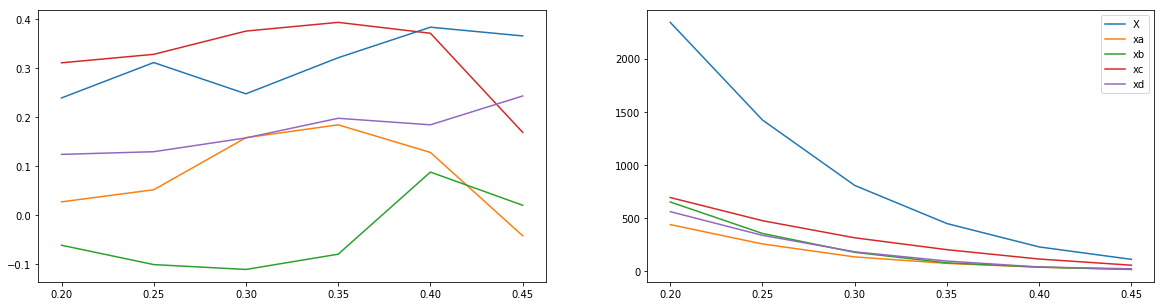

In [471]:
condition_1 = spear_thresh[spear_thresh['datafrane'] == 0]
condition_2 = spear_thresh[spear_thresh['datafrane'] == 1]
condition_3 = spear_thresh[spear_thresh['datafrane'] == 2]
condition_4 = spear_thresh[spear_thresh['datafrane'] == 3]
condition_5 = spear_thresh[spear_thresh['datafrane'] == 4]


plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(condition_1['threshold'], condition_1['spearman'], label = 'X')
plt.plot(condition_2['threshold'], condition_2['spearman'], label = 'xa')
plt.plot(condition_3['threshold'], condition_3['spearman'], label = 'xb')
plt.plot(condition_4['threshold'], condition_4['spearman'], label = 'xc')
plt.plot(condition_5['threshold'], condition_5['spearman'], label = 'xd')

plt.subplot(122)
plt.plot(condition_1['threshold'], condition_1['num_cols'], label = 'X')
plt.plot(condition_2['threshold'], condition_2['num_cols'], label = 'xa')
plt.plot(condition_3['threshold'], condition_3['num_cols'], label = 'xb')
plt.plot(condition_4['threshold'], condition_4['num_cols'], label = 'xc')
plt.plot(condition_5['threshold'], condition_5['num_cols'], label = 'xd')
plt.legend()

#### gridsearch params - use a drop_point =0.4

In [472]:
df_list = [X, xa, xb, xc, xd]

for i in df_list:
    
    X_cos = i.loc[:]
    X_cos['BioRep'] = train_data['BioRep'] 
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])
    
    drop_point = 0.4
    names = []
    
    for k in range(len(X_cos.columns)):
          if spearmanr(reps2.iloc[:, k], reps1.iloc[:, k])[0] < drop_point:
                names.append(X_cos.columns[k])
    
    X_new = X_cos.drop(names,axis=1)
    
    

    X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size = 0.33, random_state = 42)

    svc = svm.SVR()
    params = {        
             'kernel': ['rbf', 'poly', 'sigmoid'],
                  'C': [0.01, 0.1, 1, 5],
            'epsilon': [0.01,  0.1, 0.2],
              'gamma': [0.001, 0.01, 'auto'], 
             'degree': [2, 4, 6, 8],
             }

    scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}

    gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                  return_train_score=True, scoring = scoring, refit = 'spear_r')
    gs.fit(X_train, y_train) 
    scores = pd.DataFrame(gs.cv_results_)
    condition = scores['rank_test_spear_r'] == 1
    df_1 = scores[condition].reset_index(drop = True)
    print(df_1['params'].values)
    print(len(X_new.columns))
    print(df_1.loc[:, ['mean_test_spear_r', 'mean_test_r2', 'mean_train_spear_r', 'mean_train_r2'  ]])
    print("----------------------------------------------------------------------------------------------")
    

[{'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.01, 'degree': 4, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.01, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
 {'C': 0.01, 'degree': 8, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}]
228
   mean_test_spear_r  mean_test_r2  mean_train_spear_r  mean_train_r2
0           0.293049     -0.024164            0.770392       0.017878
1           0.293049     -0.024164            0.770392       0.017878
2           0.293049     -0.024164            0.770392       0.017878
3           0.293049     -0.024164            0.770392       0.017878
----------------------------------------------------------------------------------------------
[{'C': 1, 'degree': 8, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}]
37
   mean_test_spear_r  mean_test_r2  mean_train_spear_r  mean_train_r2
0           0.301175      0.002592            0.863041       0.460813
------------------------------------

{'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}

{'C': 1, 'degree': 8, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}

{'C': 5, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}

{'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'}

{'C': 5, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}

#### score

In [475]:
results_df = pd.DataFrame(index = X.index, columns = ['Actual', 'All', 'xA', 'xB', 'xC', 'xD'])
results_df['Actual'] = y['DHA_IC50']

df_list = [X, xa, xb, xc, xd]

for i in enumerate(df_list):
    X_cos = i[1].loc[:]
    X_cos['BioRep'] = train_data['BioRep'] 
    reps1 = X_cos[X_cos['BioRep']==1].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep']==2].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])
    
    drop_point = 0.4
    names = []
                
    for k in range(len(X_cos.columns)):
        if spearmanr(reps2.iloc[:, k], reps1.iloc[:, k])[0] < drop_point:
            names.append(X_cos.columns[k])

    X_new = X_cos.drop(names,axis=1)

    
    X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size = 0.33, random_state = 42)
    
    

    svc = svm.SVR(kernel = 'poly', C = 5, degree = 2, epsilon = 0.2, gamma = 0.001)


    model = svc.fit(X_train, y_train)
    pred = model.predict(X_test)

#     print("cv_spear:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring=make_scorer(spear_r)).mean() )
#     print("cv_r^2:  ", cross_val_score(svc, X_train, y_train, cv = 3).mean() )
#     print("cv_mse:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error').mean() )
#     print("---------------------------")
    print("spearman", round(spearmanr(y_test, pred)[0], 3), round(spearmanr(y_test, pred)[1], 3) )
    print(len(X_new.columns))
#     print("r^2", r2_score(y_test, pred) ) 
#     print("mse", mean_squared_error(y_test, pred) ) 
#     print("----------------------------")
#     print("train score:", model.score(X_train, y_train))
#     print("test score:    ", model.score(X_test, y_test)) 
    print("-----------------------------------------------------------------------------")
    
    for j in enumerate(X_test.index):
        results_df.loc[j[1], results_df.columns[i[0]+1]] = round(float(pred[j[0]]), 3)
    
results_df = results_df.dropna(subset = ['xA'])
results_df = results_df.astype(float)
results_df

spearman 0.354 0.097
228
-----------------------------------------------------------------------------
spearman -0.153 0.485
37
-----------------------------------------------------------------------------
spearman -0.017 0.937
38
-----------------------------------------------------------------------------
spearman 0.372 0.08
114
-----------------------------------------------------------------------------
spearman 0.075 0.734
39
-----------------------------------------------------------------------------


,Actual,All,xA,xB,xC,xD
0,2.1770,1.522,1.558,1.552,1.584,1.550
4,1.6970,1.536,1.557,1.558,1.563,1.554
5,1.6970,1.541,1.555,1.559,1.545,1.554
7,1.7990,1.360,1.552,1.556,1.449,1.553
9,0.7100,1.563,1.556,1.546,1.618,1.548
12,1.3670,1.523,1.556,1.554,1.557,1.555
16,3.4600,1.546,1.555,1.543,1.595,1.552
19,1.7650,1.664,1.554,1.557,1.632,1.549
25,1.5170,1.597,1.552,1.556,1.607,1.547
28,1.4700,1.569,1.561,1.553,1.596,1.553


interesting... when only spearman correlated features are kept, the predictions narrow immensly!

## spearman rank - with target

#### gridsearch for best threshold and params

In [326]:
np.arange(0.1,0.16, 0.01)

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15])

In [330]:
for i, df in enumerate(df_list):
    print(i)

0


In [338]:
# results_df = pd.DataFrame(index = X.index, columns = ['Actual', 'All', 'xA', 'xB', 'xC', 'xD'])
# results_df['Actual'] = y['DHA_IC50']

df_list = [X, xa, xb, xc, xd]
# df_list = [xa]

dataframe = []
threshold = []
best_params = []
test_spear = []
test_r2 = []
train_spear = []
train_r2 = []
num_columns = []


for i, df in enumerate(df_list):                  #check the df              
    names = []
    for j in np.arange(0.1,0.16, 0.01):           #check the threshold
        names = []
        drop_point = j
    
        for c in range(0, df.shape[1]):               #check the columns          
            s, p = spearmanr(df.iloc[:, c], y)
            if np.abs(s) < j:                     #if spearman rank w/ target is below threshold, drop the column
                names.append(df.columns[c])

        X_new = df.drop(names, axis = 1)


        print(X_new.shape)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size = 0.33, random_state = 42)

        svc = svm.SVR()
        params = {        
                 'kernel': ['rbf', 'poly', 'sigmoid'],
                      'C': [0.01, 0.1, 1, 5],
                'epsilon': [0.01,  0.1, 0.2],
                  'gamma': [0.001, 0.01, 'auto'], 
                 'degree': [2, 4, 5, 8],
                 }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r)}

        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                      return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        scores = pd.DataFrame(gs.cv_results_)
        condition = scores['rank_test_spear_r'] == 1
        df_1 = scores[condition].reset_index(drop = True)
#         print(df_1['params'].values)
#         print(len(X_new.columns))
#         print(df_1.loc[:, ['mean_test_spear_r', 'mean_test_r2', 'mean_train_spear_r', 'mean_train_r2'  ]])
#         print("----------------------------------------------------------------------------------------------")
        
        dataframe.append(i)
        threshold.append(j)
        best_params.append(df_1.loc[0, 'params'])
        test_spear.append(round(df_1.loc[0, 'mean_test_spear_r' ], 3))
        test_r2.append(round(df_1.loc[0, 'mean_test_r2'], 3))
        train_spear.append(round(df_1.loc[0, 'mean_train_spear_r'], 3))
        train_r2.append(round(df_1.loc[0, 'mean_train_r2'], 3))
        num_columns.append(len(X_new.columns))
        
results_spear = pd.DataFrame(list(zip(dataframe, threshold, best_params, test_spear, test_r2, train_spear, 
                            train_r2, num_columns)), 
                   columns=['x_frame', 'threshold', 'best_params', 'test_spear', 
                            'test_r2', 'train_spear', 'train_r2', 'n_columns'])            

(68, 10142)
(68, 9086)
(68, 8046)
(68, 7160)
(68, 6249)
(68, 5407)
(68, 2314)
(68, 2018)
(68, 1788)
(68, 1559)
(68, 1347)
(68, 1154)
(68, 2521)
(68, 2255)
(68, 1986)
(68, 1740)
(68, 1486)
(68, 1285)
(68, 3216)
(68, 3003)
(68, 2743)
(68, 2552)
(68, 2333)
(68, 2080)
(68, 2091)
(68, 1810)
(68, 1529)
(68, 1309)
(68, 1083)
(68, 888)


In [339]:
results_spear

,x_frame,threshold,best_params,test_spear,test_r2,train_spear,train_r2,n_columns
0,0,0.10,"{'C': 0.01, 'degree': 8, 'epsilon': 0.01, 'gam...",0.461,-0.146,0.777,-0.005,10142
1,0,0.11,"{'C': 0.1, 'degree': 8, 'epsilon': 0.01, 'gamm...",0.456,-0.097,0.840,0.262,9086
2,0,0.12,"{'C': 0.1, 'degree': 8, 'epsilon': 0.01, 'gamm...",0.505,-0.114,0.835,0.204,8046
3,0,0.13,"{'C': 0.1, 'degree': 8, 'epsilon': 0.01, 'gamm...",0.512,-0.105,0.837,0.210,7160
4,0,0.14,"{'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamm...",0.527,-0.072,0.908,0.269,6249
5,0,0.15,"{'C': 1, 'degree': 8, 'epsilon': 0.01, 'gamma'...",0.540,0.108,0.951,0.709,5407
6,1,0.10,"{'C': 0.01, 'degree': 8, 'epsilon': 0.2, 'gamm...",0.257,-0.007,0.647,0.079,2314
7,1,0.11,"{'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma':...",0.256,-0.040,0.956,0.809,2018
8,1,0.12,"{'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma':...",0.317,-0.029,0.963,0.863,1788
9,1,0.13,"{'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma':...",0.324,-0.023,0.954,0.863,1559


In [360]:
for i, j in enumerate(results_spear['best_params']):
    print(i, j)
    

0 {'C': 0.01, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
1 {'C': 0.1, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
2 {'C': 0.1, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
3 {'C': 0.1, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
4 {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
5 {'C': 1, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
6 {'C': 0.01, 'degree': 8, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}
7 {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
8 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
9 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
10 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
11 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
12 {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
13 {'C': 5, 'degree

4 {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
5 {'C': 1, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'} #overfit
    
10 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
11 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}

17 {'C': 0.01, 'degree': 8, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}

20 {'C': 5, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}#overfit
22 {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'poly'}

25 {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
29 {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}


poly, , c = 1, 0.1, degree 8 epsilon = 0.01 gamma = 0.001 
        c=  0.1  degree 2 epsilon = 0.2  gamma = 0.001
        'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 0.001
rbf, c= 0.1 degreee=2, epsioln = 0.01 gamma = 0.001
    c= 0.1 degreee=2, epsioln = 0.2, gamma =0.001
    c= 5 degreee=2, epsioln = 0.2, gamma =0.01 
     c= 5 degreee=2, epsioln = 0.01, gamma =0.001 

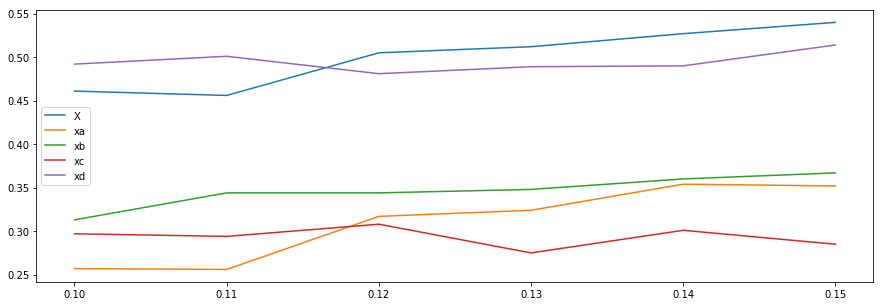

In [347]:
condition_1 = results_spear[results_spear['x_frame'] == 0]
condition_2 = results_spear[results_spear['x_frame'] == 1]
condition_3 = results_spear[results_spear['x_frame'] == 2]
condition_4 = results_spear[results_spear['x_frame'] == 3]
condition_5 = results_spear[results_spear['x_frame'] == 4]
# condition_1

plt.figure(figsize=(15, 5))
plt.plot(condition_1['threshold'], condition_1['test_spear'], label = 'X')
plt.plot(condition_2['threshold'], condition_2['test_spear'], label = 'xa')
plt.plot(condition_3['threshold'], condition_3['test_spear'], label = 'xb')
plt.plot(condition_4['threshold'], condition_4['test_spear'], label = 'xc')
plt.plot(condition_5['threshold'], condition_5['test_spear'], label = 'xd')

plt.legend()

#### score (from spearman w/ target)
poly, , c = 1, 0.1, degree 8 epsilon = 0.01 gamma = 0.001 
        c=  0.1  degree 2 epsilon = 0.2  gamma = 0.001
        'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 0.001
rbf, c= 0.1 degreee=2, epsioln = 0.01 gamma = 0.001
    c= 0.1 degreee=2, epsioln = 0.2, gamma =0.001
    c= 5 degreee=2, epsioln = 0.2, gamma =0.01 
     c= 5 degreee=2, epsioln = 0.01, gamma =0.001 

In [361]:
results_df = pd.DataFrame(index = X.index, columns = ['Actual', 'All', 'xA', 'xB', 'xC', 'xD'])
results_df['Actual'] = y['DHA_IC50']

df_list = [X, xa, xb, xc, xd]

for i, df in enumerate(df_list):                  #check the df              
    names = []

    for c in range(0, df.shape[1]):               #check the columns          
        s, p = spearmanr(df.iloc[:, c], y)
        if np.abs(s) < 0.15:                     #if spearman rank w/ target is below threshold, drop the column
            names.append(df.columns[c])

    X_new = df.drop(names, axis = 1)


    print(X_new.shape)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size = 0.33, random_state = 42)


    svc = svm.SVR(kernel = 'poly', C = 1, degree = 8, epsilon = 0.01, gamma = 0.001)
    model = svc.fit(X_train, y_train)
    pred = model.predict(X_test)

    #     print("cv_spear:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring=make_scorer(spear_r)).mean() )
    #     print("cv_r^2:  ", cross_val_score(svc, X_train, y_train, cv = 3).mean() )
    #     print("cv_mse:  ", cross_val_score(svc, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error').mean() )
    #     print("---------------------------")
    print("spearman", round(spearmanr(y_test, pred)[0], 3), round(spearmanr(y_test, pred)[1], 3) ) 
    #     print("r^2", r2_score(y_test, pred) ) 
    #     print("mse", mean_squared_error(y_test, pred) ) 
    #     print("----------------------------")
    #     print("train score:", model.score(X_train, y_train))
    #     print("test score:    ", model.score(X_test, y_test)) 
    print("-----------------------------------------------------------------------------")

    
#????????????    
    for j in enumerate(X_test.index):
        results_df.loc[j[1], results_df.columns[i+1]] = round(float(pred[j[0]]), 3)

results_df = results_df.dropna(subset = ['xA'])
results_df = results_df.astype(float)
results_df

(68, 5407)
spearman 0.167 0.448
-----------------------------------------------------------------------------
(68, 1154)
spearman 0.118 0.592
-----------------------------------------------------------------------------
(68, 1285)
spearman 0.34 0.112
-----------------------------------------------------------------------------
(68, 2080)
spearman 0.108 0.625
-----------------------------------------------------------------------------
(68, 888)
spearman 0.333 0.121
-----------------------------------------------------------------------------


,Actual,All,xA,xB,xC,xD
0,2.1770,1.325,3.497,1.547,1.878,1.470
4,1.6970,1.390,1.540,1.647,0.736,1.655
5,1.6970,1.705,1.449,1.617,1.981,1.466
7,1.7990,1.142,1.514,1.669,-0.223,4.589
9,0.7100,1.665,1.449,1.157,2.125,1.415
12,1.3670,1.524,1.757,1.333,1.485,1.576
16,3.4600,1.542,1.477,-1.673,1.915,1.881
19,1.7650,1.728,1.579,1.702,1.554,1.454
25,1.5170,1.692,1.448,1.774,1.804,1.613
28,1.4700,1.618,1.441,1.277,1.769,1.510


In [362]:
results_df.describe()

,Actual,All,xA,xB,xC,xD
count,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000
mean,1.626187,1.591130,1.575913,1.501043,1.33087,1.668783
std,0.552998,0.236324,0.437517,0.727434,0.72845,0.646812
min,0.693300,1.082000,1.257000,-1.673000,-0.22300,1.415000
25%,1.348000,1.419500,1.441500,1.525500,0.84200,1.467500
50%,1.647000,1.665000,1.474000,1.669000,1.65700,1.494000
75%,1.782000,1.730000,1.558000,1.740000,1.89150,1.594500
max,3.460000,2.037000,3.497000,2.190000,2.12500,4.589000


In [364]:


results_df['Avg_4'] = (results_df['xA'] + results_df['xB'] + results_df['xC'] + results_df['xD']) / 4

results_df['Avg_ad'] = (results_df['xA'] + results_df['xD']) / 2
results_df['Avg_ac'] = (results_df['xA'] + results_df['xC']) / 2
results_df['Avg_ab'] = (results_df['xA'] + results_df['xB']) / 2  

results_df['Avg_bc'] = (results_df['xB'] + results_df['xC']) / 2 
results_df['Avg_bd'] = (results_df['xB'] + results_df['xD']) / 2 

results_df['Avg_cd'] = (results_df['xC'] + results_df['xD']) / 2 

results_df
print('Avg_4', round(spearmanr(results_df['Avg_4'], results_df['Actual'])[0], 3))
print("------------------------------------------------")
print('ad', round(spearmanr(results_df['Avg_ad'], results_df['Actual'])[0], 3))
print('ac', round(spearmanr(results_df['Avg_ac'], results_df['Actual'])[0], 3))
print('ab', round(spearmanr(results_df['Avg_ab'], results_df['Actual'])[0], 3))
print("------------------------------------------------")
print('bc', round(spearmanr(results_df['Avg_bc'], results_df['Actual'])[0], 3))
print('bd', round(spearmanr(results_df['Avg_bd'], results_df['Actual'])[0], 3))
print('cd', round(spearmanr(results_df['Avg_cd'], results_df['Actual'])[0], 3))


Avg_4 0.295
------------------------------------------------
ad 0.401
ac 0.112
ab 0.448
------------------------------------------------
bc 0.108
bd 0.414
cd 0.32
